## 1. Постановка задачи

<center> <img src=https://i.pinimg.com/originals/43/4c/ef/434cefb46a1b7d0764def9af0817fc7e.jpg align="right" width="300"/> </center>
    
В данном проекте необходимо решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [3]:
taxi_data = pd.read_csv("Data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Условно разделим признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

Для начала посмотрим на временные рамки, в которых мы работаем с данными.

In [4]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

display(taxi_data['pickup_datetime'].describe())

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

Посмотрим на пропуски. 

In [5]:
display(taxi_data.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Посмотрим на статистические характеристики некоторых признаков. 

In [6]:
display(taxi_data.describe())

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,2016-04-01 10:10:24.940037120,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
min,1.000000e+00,2016-01-01 00:00:17,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,2016-02-17 16:46:04.249999872,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,2016-04-01 17:19:40,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2016-05-15 03:56:08.750000128,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,2016-06-30 23:59:39,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06
std,4.987772e-01,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


In [7]:
daysofweek = {0: 'Monday', 
              1: 'Tuesday',
              2: 'Wednesday',
              3: 'Thursday',
              4: 'Friday',
              5: 'Saturday',
              6: 'Sunday'
               }

def add_datetime_features(DF):
    DF['pickup_date'] = DF['pickup_datetime'].dt.date
    DF['pickup_hour'] = DF['pickup_datetime'].dt.hour
    DF['pickup_day_of_week'] = DF['pickup_datetime'].dt.weekday
    DF['pickup_day_of_week'] = DF['pickup_day_of_week'].replace(daysofweek)
    return DF

taxi_data = add_datetime_features(taxi_data)
display(taxi_data.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday


In [8]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

def add_holiday_features(taxi_data, holiday_data):
    holiday_dates = list(holiday_data['date'])
    taxi_data['pickup_holiday'] = taxi_data['pickup_date'].apply(lambda x: 1 if str(x) in holiday_dates else 0)
    return taxi_data

taxi_data = add_holiday_features(taxi_data, holiday_data)

In [ ]:
osrm_data = pd.read_csv('data/osrm_data_train.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

def add_osrm_features(taxi_data, osrm_data):
    taxi_data = pd.merge(taxi_data, osrm_data, on='id', how='left')
    return taxi_data

taxi_data = add_osrm_features(taxi_data, osrm_data)

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [10]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.


In [11]:
def add_geographical_features(taxi_data):
    taxi_data['haversine_distance'] = get_haversine_distance(taxi_data['pickup_latitude'], taxi_data['pickup_longitude'], taxi_data['dropoff_latitude'], taxi_data['dropoff_longitude'])
    taxi_data['direction'] = get_angle_direction(taxi_data['pickup_latitude'], taxi_data['pickup_longitude'], taxi_data['dropoff_latitude'], taxi_data['dropoff_longitude'])
    return taxi_data

taxi_data = add_geographical_features(taxi_data)

Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [12]:
kmeans = cluster.KMeans(n_clusters=10, random_state=42)

def add_cluster_features(taxi_data, kmeans):
    coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
    kmeans.fit(coords)
    taxi_data['geo_cluster'] = kmeans.predict(coords)
    return taxi_data

taxi_data = add_cluster_features(taxi_data, kmeans)

c:\Users\romep\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.


In [13]:
weather_data = pd.read_csv('data/weather_data.csv', usecols=['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events'])

weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')
weather_data['date'] = weather_data['time'].dt.date
weather_data['hour'] = weather_data['time'].dt.hour

weather_data = weather_data.drop('time', axis=1)

def add_weather_features(taxi_data, weather_data):
    taxi_data = pd.merge(taxi_data, weather_data, left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')
    return taxi_data

taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data = taxi_data.drop(['date', 'hour'], axis=1)

Реализуем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.


In [14]:
def fill_null_weather_data(taxi_data):
    taxi_data['temperature'] = taxi_data['temperature'].fillna(taxi_data.groupby('pickup_date')['temperature'].transform('median'))
    taxi_data['visibility'] = taxi_data['visibility'].fillna(taxi_data.groupby('pickup_date')['visibility'].transform('median'))
    taxi_data['wind speed'] = taxi_data['wind speed'].fillna(taxi_data.groupby('pickup_date')['wind speed'].transform('median'))
    taxi_data['precip'] = taxi_data['precip'].fillna(taxi_data.groupby('pickup_date')['precip'].transform('median'))
    taxi_data['events'] = taxi_data['events'].fillna('None')
    taxi_data['total_distance'] = taxi_data['total_distance'].fillna(taxi_data['total_distance'].median())
    taxi_data['total_travel_time'] = taxi_data['total_travel_time'].fillna(taxi_data['total_travel_time'].median())
    taxi_data['number_of_steps'] = taxi_data['number_of_steps'].fillna(taxi_data['number_of_steps'].median())
    return taxi_data

taxi_data = fill_null_weather_data(taxi_data)

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


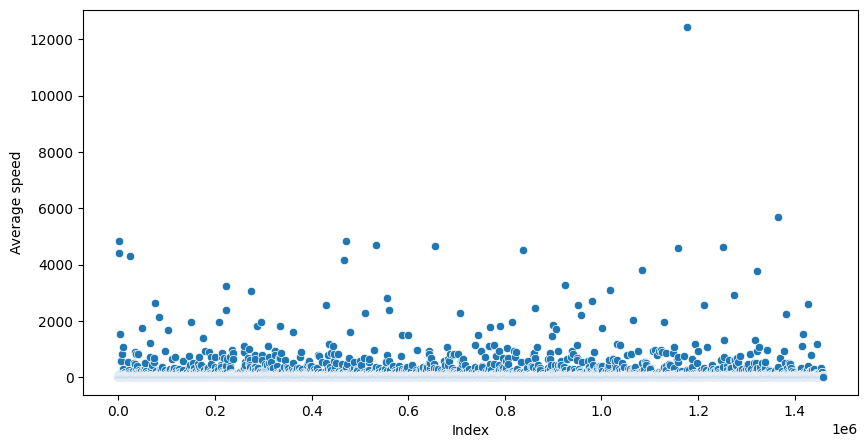

In [15]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


In [17]:
outliers_duration = taxi_data[ taxi_data['trip_duration'] / 3600 > 24 ]
outliers_speed = taxi_data[ 3.6 * taxi_data['total_distance'] / taxi_data['trip_duration'] > 300 ]

taxi_data.drop(outliers_duration.index, inplace=True)
taxi_data.drop(outliers_speed.index, inplace=True)

## 3. Разведывательный анализ данных (EDA)

В этой части проекта мы:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;

Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [16]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 

Ненормальное Распределение


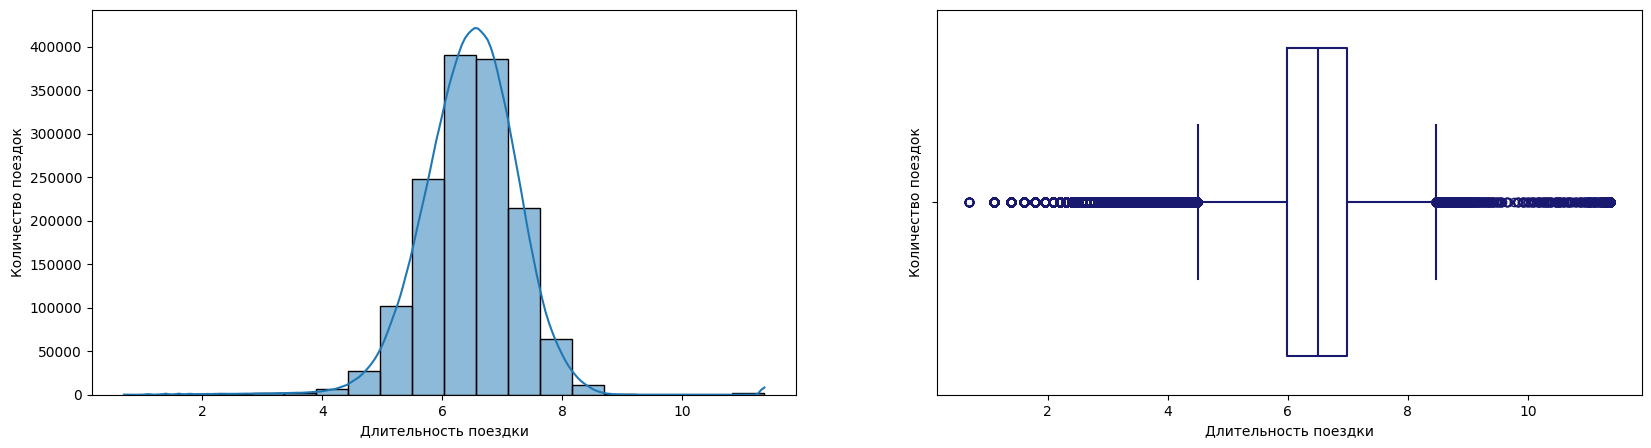

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.histplot(data=taxi_data, x='trip_duration_log', ax=ax[0], kde=True, bins=20)
sns.boxplot(data=taxi_data, x='trip_duration_log', ax=ax[1], fill=False, color='midnightblue')

ax[0].set_xlabel('Длительность поездки')
ax[0].set_ylabel('Количество поездок')
ax[1].set_xlabel('Длительность поездки')
ax[1].set_ylabel('Количество поездок');

stat, pvalue = stats.normaltest(taxi_data['trip_duration_log'])

if(pvalue < 0.05):
    print('Ненормальное Распределение')
else:
    print('Нормальное Распределение')

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

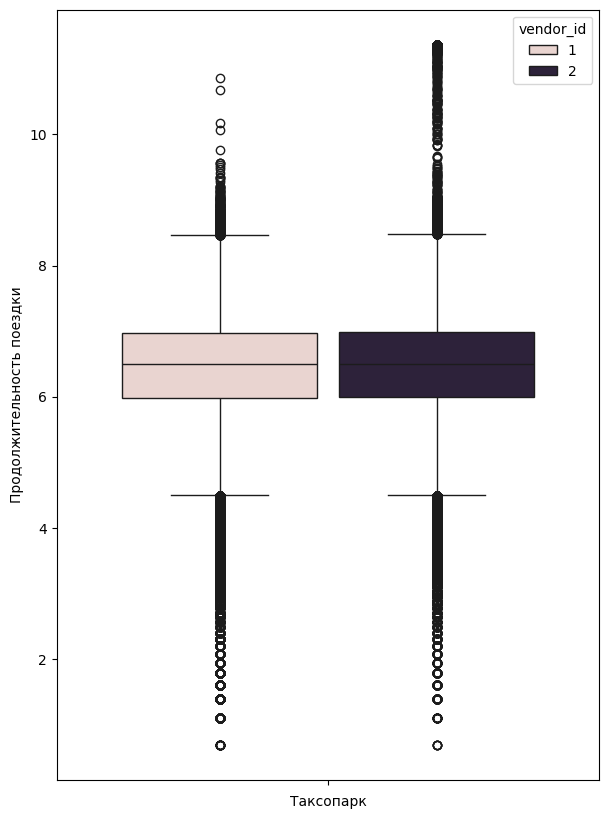

In [19]:
fig, ax = plt.subplots(figsize=(7,10))

sns.boxplot(data=taxi_data, hue='vendor_id', y='trip_duration_log', gap=.1)

ax.set_xlabel('Таксопарк')
ax.set_ylabel('Продолжительность поездки');

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

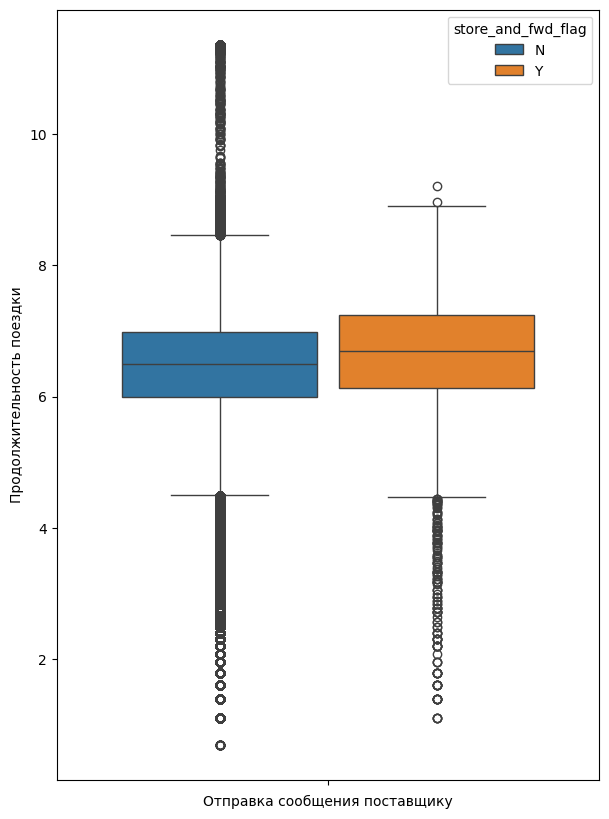

In [20]:
fig, ax = plt.subplots(figsize=(7,10))

sns.boxplot(data=taxi_data, hue='store_and_fwd_flag', y='trip_duration_log', gap=.1)

ax.set_xlabel('Отправка сообщения поставщику')
ax.set_ylabel('Продолжительность поездки');

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

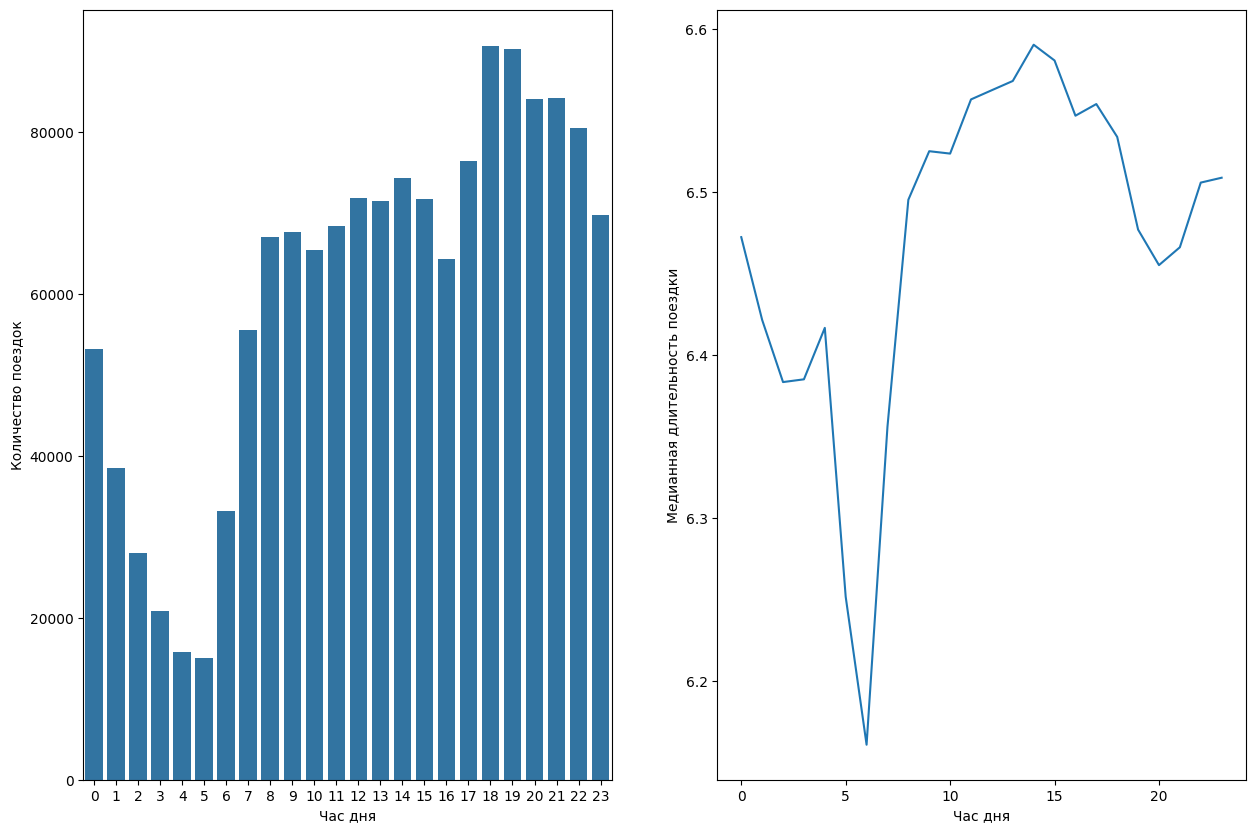

In [21]:
group_data = taxi_data.groupby('pickup_hour')['trip_duration_log'].median()

fig, ax = plt.subplots(1, 2, figsize=(15,10))

sns.countplot(data=taxi_data, x='pickup_hour', ax=ax[0])
group_data.plot(ax=ax[1])

ax[0].set_xlabel('Час дня')
ax[0].set_ylabel('Количество поездок')
ax[1].set_xlabel('Час дня')
ax[1].set_ylabel('Медианная длительность поездки');

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

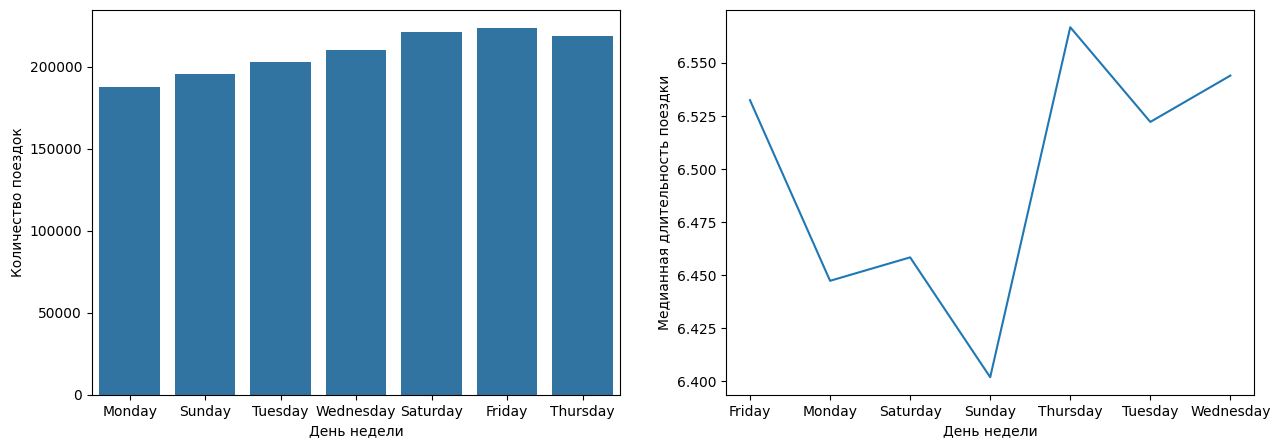

In [23]:
group_data = taxi_data.groupby('pickup_day_of_week')['trip_duration_log'].median()

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.countplot(data=taxi_data, x='pickup_day_of_week', ax=ax[0])
group_data.plot(ax=ax[1])

ax[0].set_xlabel('День недели')
ax[0].set_ylabel('Количество поездок')
ax[1].set_xlabel('День недели')
ax[1].set_ylabel('Медианная длительность поездки');

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

<Axes: xlabel='pickup_day_of_week', ylabel='pickup_hour'>

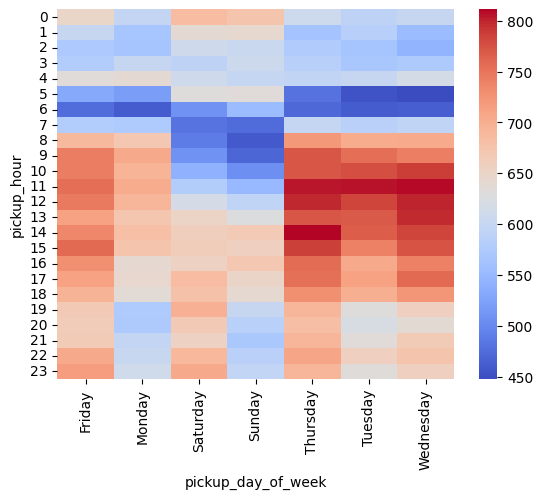

In [24]:
pivot_table = pd.pivot_table(data=taxi_data,index='pickup_hour', columns='pickup_day_of_week', values='trip_duration', aggfunc='median')
display(sns.heatmap(data=pivot_table, cmap='coolwarm'));

Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

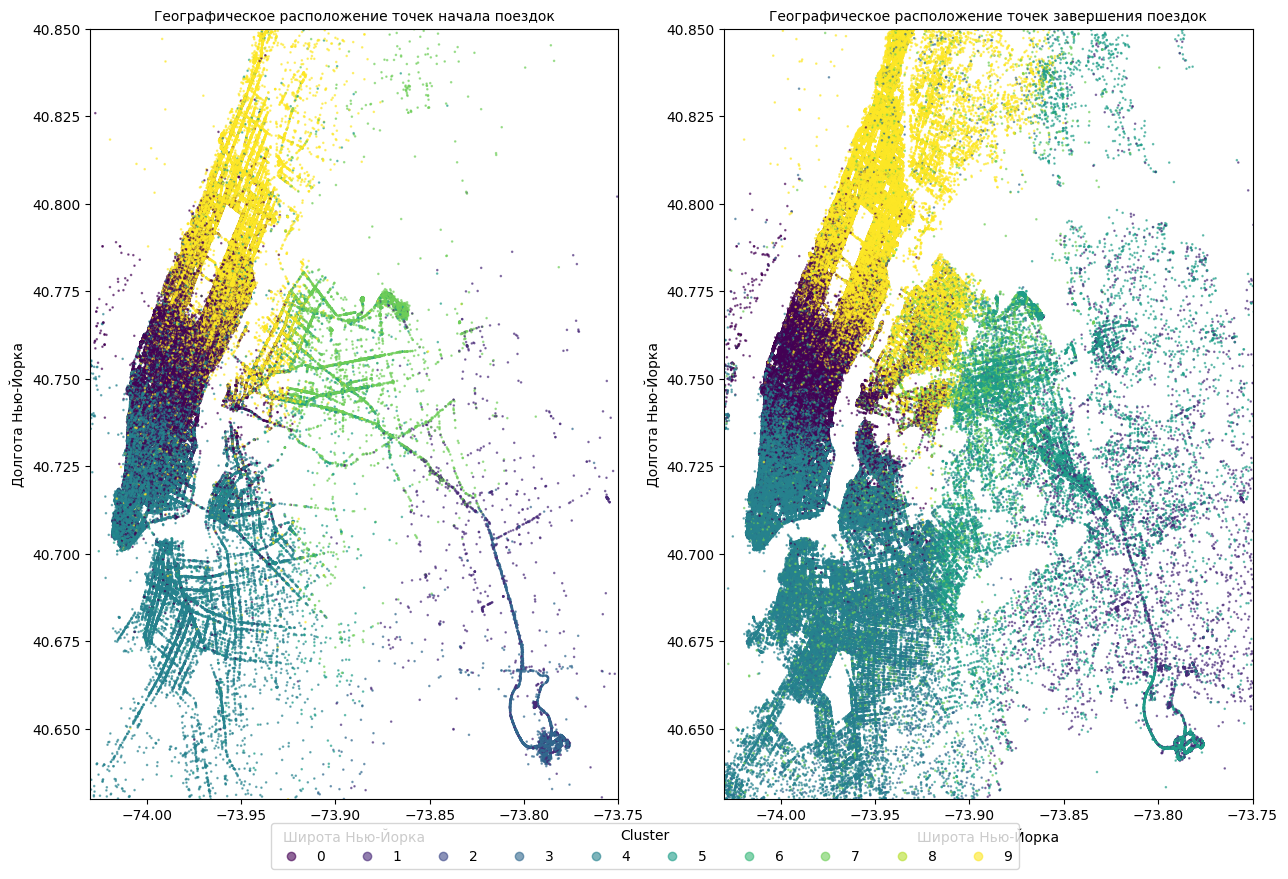

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].set_title('Географическое расположение точек начала поездок', fontsize=10)
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
ax[0].set_xlabel('Широта Нью-Йорка')
ax[0].set_ylabel('Долгота Нью-Йорка')

ax[1].set_title('Географическое расположение точек завершения поездок', fontsize=10)
ax[1].set_xlim(city_long_border)
ax[1].set_ylim(city_lat_border)
ax[1].set_xlabel('Широта Нью-Йорка')
ax[1].set_ylabel('Долгота Нью-Йорка')

scatter_1 = ax[0].scatter(x = taxi_data.pickup_longitude,                       # данные по оси абсцисс
            y = taxi_data.pickup_latitude,                                      # данные по оси ординат
            s = 0.7,                                                                # размер точек (от 0 до 1)
            c = taxi_data.geo_cluster,                                          # цвет точек (явно ссылаемся на данные)
            alpha = 0.6                                                             # прозрачность точек (от 0 до 1)
            )

scatter_2 = ax[1].scatter(x = taxi_data.dropoff_longitude, 
            y = taxi_data.dropoff_latitude, 
            s = 0.7,
            c = taxi_data.geo_cluster,
            alpha = 0.6)

plt.legend(*scatter_1.legend_elements(),                  # используем внутренний метод для построения легенды                          
           title = 'Cluster',                             # задаём общее название для легенды
           loc='lower center',                            # расположение легенды
           bbox_to_anchor=(-0.15, -0.1),                  # корректировка расположения (чтобы вывести из поля графиков)
           ncol=taxi_data.geo_cluster.nunique())      # ссылаемся на количество уникальных кластеров в данных

plt.show()

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [28]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [29]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

In [30]:
train_data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [31]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Закодируeм признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

In [32]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x.strip() == 'N' else 1)

Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. 

In [33]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

one_hot_encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')

data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out()
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

display(data_onehot.head())

,pickup_day_of_week_Monday,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками:

In [34]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [35]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [36]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе.

In [37]:
select = feature_selection.SelectKBest(k=25, score_func=feature_selection.f_regression)

select.fit(X_train, y_train_log)

selected_features = select.get_feature_names_out()

X_train = X_train[selected_features]
X_valid = X_valid[selected_features]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn.

In [39]:
minmaxscaler = preprocessing.MinMaxScaler()

minmaxscaler.fit(X_train, y_train_log)

column_names = X_train.columns

X_train_scale = pd.DataFrame(minmaxscaler.transform(X_train), columns=column_names)
X_valid_scale = pd.DataFrame(minmaxscaler.transform(X_valid), columns=column_names)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Построим модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

In [40]:
lg = linear_model.LinearRegression()

lg.fit(X_train_scale, y_train_log)

y_pred_train = lg.predict(X_train_scale)
y_pred_valid = lg.predict(X_valid_scale)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))

print(f'RMSLE на тестовой выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

RMSLE на тестовой выборке: 0.54
RMSLE на валидационной выборке: 0.54


Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. 

In [41]:
polynomialfeatures = preprocessing.PolynomialFeatures(include_bias=False, degree=2)

polynomialfeatures.fit(X_train_scale, y_train_log)

column_names = polynomialfeatures.get_feature_names_out()

X_train_scale_poly = pd.DataFrame(polynomialfeatures.transform(X_train_scale), columns=column_names)
X_valid_scale_poly = pd.DataFrame(polynomialfeatures.transform(X_valid_scale), columns=column_names)

lg.fit(X_train_scale_poly, y_train_log)

y_pred_train = lg.predict(X_train_scale_poly)
y_pred_valid = lg.predict(X_valid_scale_poly)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))

print(f'RMSLE на тестовой выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

RMSLE на тестовой выборке: 0.47
RMSLE на валидационной выборке: 0.7


Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке.

In [42]:
rg = linear_model.Ridge(alpha=1)

rg.fit(X_train_scale_poly, y_train_log)

y_pred_train = rg.predict(X_train_scale_poly)
y_pred_valid = rg.predict(X_valid_scale_poly)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))

print(f'RMSLE на тестовой выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

RMSLE на тестовой выборке: 0.48
RMSLE на валидационной выборке: 0.48


Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке.

In [43]:
dt = tree.DecisionTreeRegressor(random_state = 42)

dt.fit(X_train_scale, y_train_log)

y_pred_train = dt.predict(X_train_scale)
y_pred_valid = dt.predict(X_valid_scale)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))

print(f'RMSLE на тестовой выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

RMSLE на тестовой выборке: 0.0
RMSLE на валидационной выборке: 0.57


Найдем оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

In [44]:
def select_depth(X_train_scale, X_valid_scale, y_train_log, y_valid_log):
    rmlse_train_list = []
    rmlse_valid_list = []

    for depth in range(7, 20):

        dt = tree.DecisionTreeRegressor(max_depth=depth,random_state = 42)

        dt.fit(X_train_scale, y_train_log)

        y_pred_train = dt.predict(X_train_scale)
        y_pred_valid = dt.predict(X_valid_scale)

        rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))
        rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))

        rmlse_train_list.append(rmsle_train)
        rmlse_valid_list.append(rmsle_valid)
    
    return rmlse_train_list, rmlse_valid_list

rmlse_train_list, rmlse_valid_list = select_depth(X_train_scale, X_valid_scale, y_train_log, y_valid_log)

<Axes: >

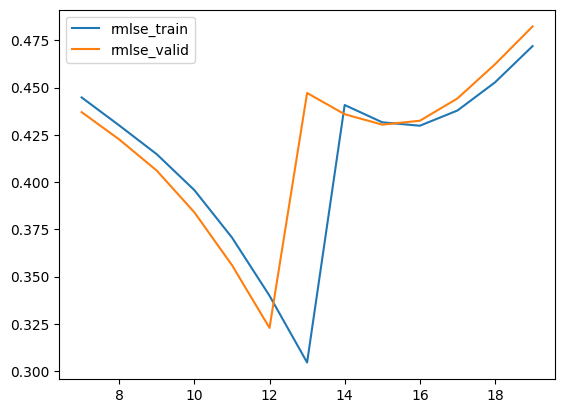

In [45]:
np.array(rmlse_train_list).reshape((-1,1))
rmlse_df = pd.DataFrame(data=np.array([rmlse_train_list, rmlse_valid_list]).reshape((-1,2)), columns=['rmlse_train', 'rmlse_valid'], index=range(7,20))
rmlse_df.plot()

In [46]:
dt = tree.DecisionTreeRegressor(max_depth=12,random_state = 42)

dt.fit(X_train_scale, y_train_log)

y_pred_train = dt.predict(X_train_scale)
y_pred_valid = dt.predict(X_valid_scale)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))

print(f'RMSLE на тестовой выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

RMSLE на тестовой выборке: 0.41
RMSLE на валидационной выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

In [47]:
rf = ensemble.RandomForestRegressor(n_estimators=200, max_depth=12, criterion='squared_error', min_samples_split=20, random_state=42)

rf.fit(X_train_scale, y_train_log)

y_pred_train = rf.predict(X_train_scale)
y_pred_valid = rf.predict(X_valid_scale)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid))

print(f'RMSLE на тестовой выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

RMSLE на тестовой выборке: 0.4
RMSLE на валидационной выборке: 0.41


In [50]:
gbr = ensemble.GradientBoostingRegressor(learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=20, random_state=42, verbose=True)

gbr.fit(X_train_scale, y_train_log)

y_pred_train_gbr = gbr.predict(X_train_scale)
y_pred_valid_gbr = gbr.predict(X_valid_scale)

rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_pred_train_gbr))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_pred_valid_gbr))

print(f'RMSLE на тестовой выборке: {rmsle_train.round(2)}')
print(f'RMSLE на валидационной выборке: {rmsle_valid.round(2)}')

      Iter       Train Loss   Remaining Time 
         1           0.3110           10.56m
         2           0.2247           10.34m
         3           0.1987           10.12m
         4           0.1875           10.02m
         5           0.1821           10.00m
         6           0.1789            9.82m
         7           0.1742            9.80m
         8           0.1721            9.59m
         9           0.1705            9.38m
        10           0.1693            9.24m
        20           0.1574            7.97m
        30           0.1526            6.89m
        40           0.1496            5.87m
        50           0.1462            4.89m
        60           0.1447            3.92m
        70           0.1425            2.93m
        80           0.1404            1.95m
        90           0.1391           58.26s
       100           0.1376            0.00s
RMSLE на тестовой выборке: 0.37
RMSLE на валидационной выборке: 0.39


Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

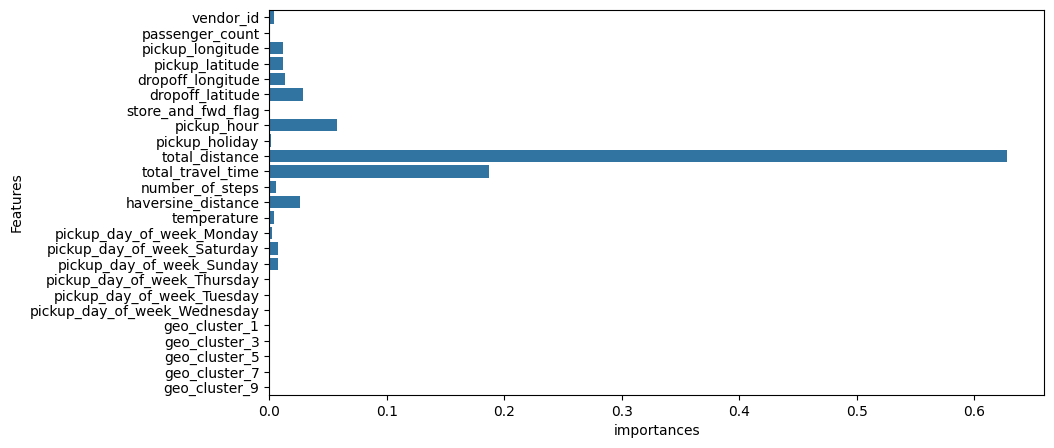

In [51]:
importances = gbr.feature_importances_.reshape((-1,1))
importances_df = pd.DataFrame(data=importances, index=X_train_scale.columns, columns=['importances'])

fix, ax = plt.subplots(figsize=(10, 5))

sns.barplot(data=importances_df, x='importances', y=importances_df.index)

ax.set_ylabel('Features');

Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке.


In [52]:
y_train = np.exp(y_train_log)-1
y_valid = np.exp(y_valid_log)-1

y_pred_train = np.exp(y_pred_train_gbr)-1
y_pred_valid = np.exp(y_pred_valid_gbr)-1

print(f'RMSLE на тестовой выборке: {round(metrics.median_absolute_error(y_train, y_pred_train)/60, 1)}')
print(f'RMSLE на валидационной выборке: {round(metrics.median_absolute_error(y_valid, y_pred_valid)/60, 1)}')

RMSLE на тестовой выборке: 1.8
RMSLE на валидационной выборке: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [56]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [57]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[selected_features]
X_test_scaled = minmaxscaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

c:\Users\romep\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of data: (625134, 25)


In [58]:
y_test_predict = gbr.predict(X_test_scaled)

y_test_predict = np.exp(y_test_predict)-1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

c:\Users\romep\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [59]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [60]:
# Создание матриц наблюдений в формате DMatrix
best_features = list(select.get_feature_names_out())
dtrain = xgb.DMatrix(X_train_scale, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scale, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [61]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73992	valid-rmse:0.74194
[10]	train-rmse:0.49093	valid-rmse:0.49351
[20]	train-rmse:0.44059	valid-rmse:0.44344
[30]	train-rmse:0.42595	valid-rmse:0.42899
[40]	train-rmse:0.41826	valid-rmse:0.42145
[50]	train-rmse:0.41278	valid-rmse:0.41628
[60]	train-rmse:0.40921	valid-rmse:0.41297
[70]	train-rmse:0.40578	valid-rmse:0.40984
[80]	train-rmse:0.40266	valid-rmse:0.40697
[90]	train-rmse:0.40070	valid-rmse:0.40529
[100]	train-rmse:0.39897	valid-rmse:0.40397
[110]	train-rmse:0.39740	valid-rmse:0.40265
[120]	train-rmse:0.39626	valid-rmse:0.40178
[130]	train-rmse:0.39502	valid-rmse:0.40086
[140]	train-rmse:0.39424	valid-rmse:0.40034
[150]	train-rmse:0.39301	valid-rmse:0.39936
[160]	train-rmse:0.39220	valid-rmse:0.39888
[170]	train-rmse:0.39146	valid-rmse:0.39832
[180]	train-rmse:0.39072	valid-rmse:0.39789
[190]	train-rmse:0.39009	valid-rmse:0.39756
[200]	train-rmse:0.38924	valid-rmse:0.39706
[210]	train-rmse:0.38877	valid-rmse:0.39680
[220]	train-rmse:0.38794	valid-rmse:0.39626

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [62]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39412


In [63]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_xgb.csv', index=False)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

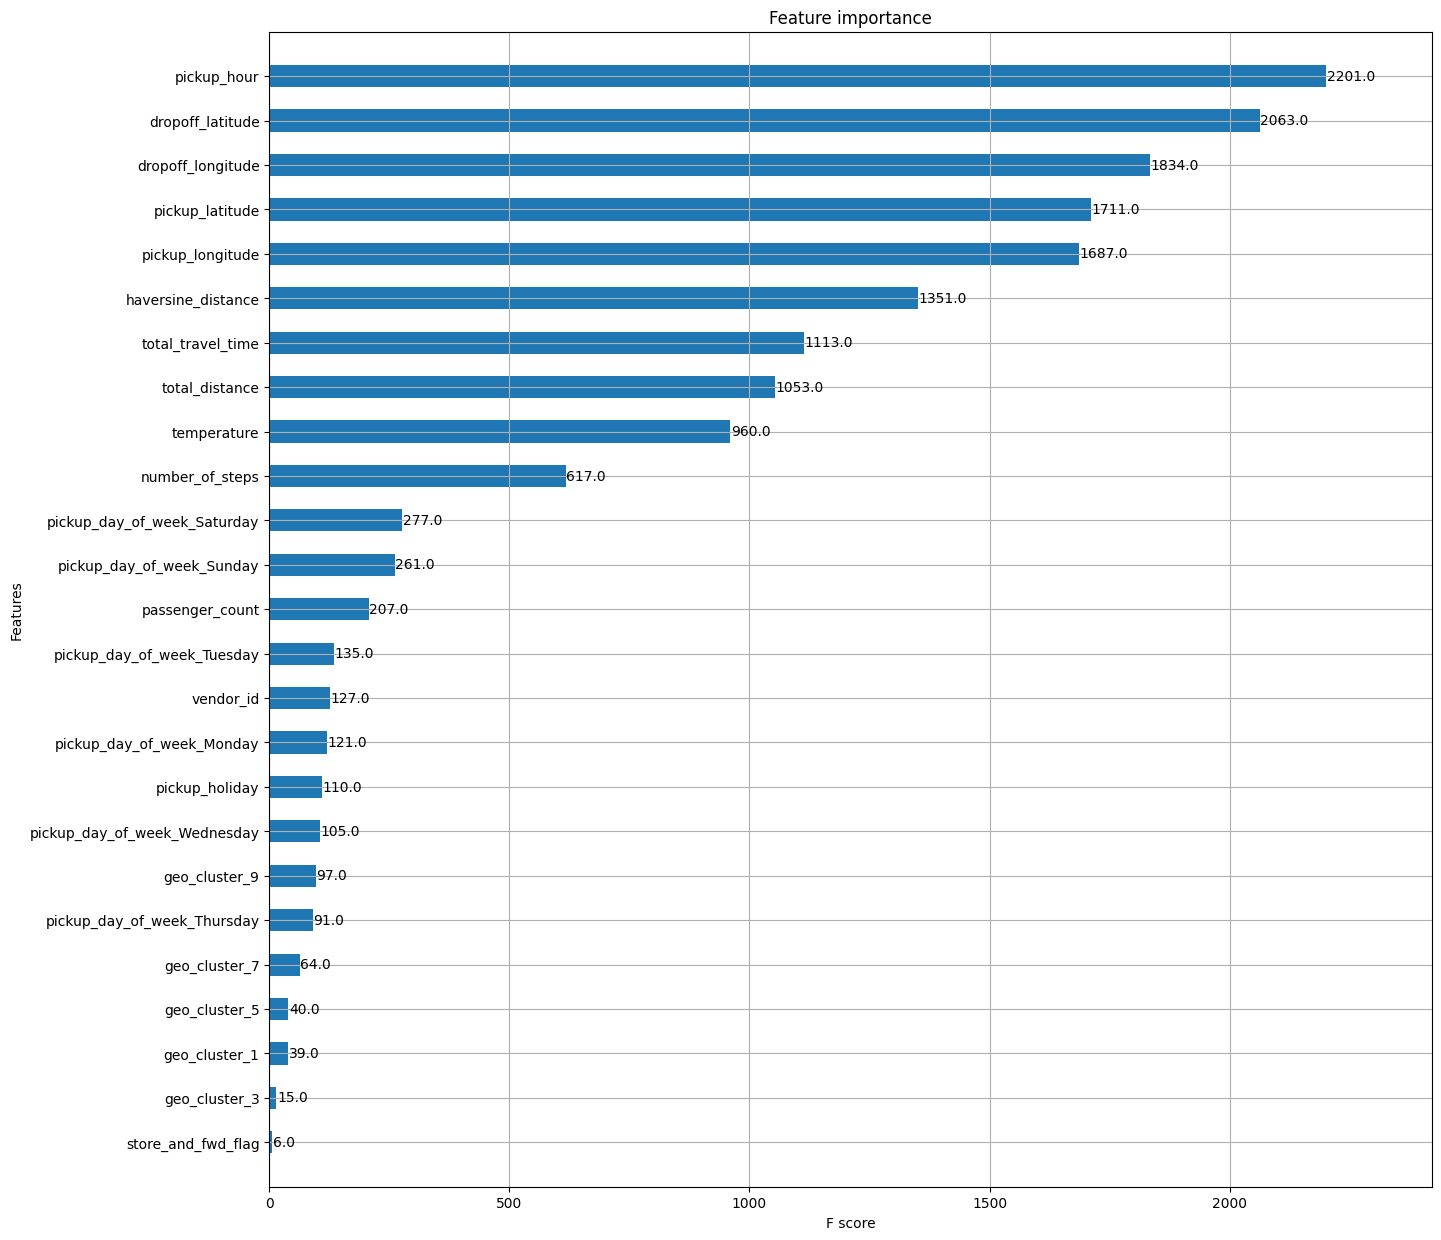

In [64]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)